# Событийный анализ мобильного приложения

## Оглавление

* [Цель проекта](#purpose)
* [Исходные данные](#data)
* [Предобработка данных](#preprocessing)
* [Первичный анализ данных](#analysis)
* [Воронка событий](#funnel)
* [Результаты A/A/B-теста](#aabtest)
  * [Проверка гипотезы об отсутствии различий в конверсии двух контрольных групп](#a1a2test)
  * [Проверка гипотезы об отсутствии различий в конверсии между экспериментальной и каждой из контрольных групп](#a1a2btest)
  * [Проверка гипотезы об отсутствии различий в конверсии между экспериментальной и объединённой контрольной группой](#abtest)
* [Выводы](#conclusions)


## Цель проекта <a id="purpose"></a>

В этом проекте мы анализируем эффективность продаж продуктов питания в мобильном приложении небольшого стартапа: смотрим воронку продаж, обрабатываем результаты A/A/B-тестирования по результатам эксперимента (замена шрифтов в приложении).

## Исходные данные <a id="data"></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mth
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
#import warnings 
#warnings.filterwarnings('ignore')

In [3]:
log_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/logs_exp.csv', sep = '\t')
log_data.info()
log_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Файл с данными содержит список с названиями, временем событий, произошедших в приложении с каждым пользователем, а также идентификатор группы теста: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных <a id="preprocessing"></a>

Переименуем столбцы в соответствии со стандартом.

In [4]:
log_data.columns = ['event_name', 'id', 'dt', 'exp_group']

Дата события в таблице указана в формате unix timestamp. Приведем ее к привычному виду.

In [5]:
log_data['datetime'] = pd.to_datetime(log_data['dt'], unit = 's')
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   id          244126 non-null  int64         
 2   dt          244126 non-null  int64         
 3   exp_group   244126 non-null  int64         
 4   datetime    244126 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


Добавим столбец даты события.

In [6]:
log_data['date'] = log_data['datetime'].dt.date
log_data['date'].tail()

244121    2019-08-07
244122    2019-08-07
244123    2019-08-07
244124    2019-08-07
244125    2019-08-07
Name: date, dtype: object

Найдем и уберем дубликаты.

In [7]:
print('В таблице {} дублирующихся строк.'.format(log_data.duplicated().sum()))

В таблице 413 дублирующихся строк.


In [8]:
log_data = log_data.drop_duplicates()
print('После обработки в таблице осталось {} дублирующихся строк.'.format(log_data.duplicated().sum()))

После обработки в таблице осталось 0 дублирующихся строк.


Проверим таблицу на пропуски.

In [9]:
log_data.isna().sum()

event_name    0
id            0
dt            0
exp_group     0
datetime      0
date          0
dtype: int64

Пропусков в таблице нет, дубликаты удалены. Можно приступать к анализу данных.

## Первичный анализ данных <a id="analysis"></a>

Определим количество событий, рассматриваемых в таблице, количество уникальных пользователей и среднее количество событий, приходящихся на одного пользователя.

In [10]:
print('В логе {} типов событий.'.format(log_data['event_name'].nunique()))
print('В логе зафиксирована активность {} пользователей.'.format(log_data['id'].nunique()))
len(log_data['event_name']) / log_data['id'].nunique()
print('В среднем один пользователь участвует в {:.0f} событиях.'.format(len(log_data) / log_data['id'].nunique()))

В логе 5 типов событий.
В логе зафиксирована активность 7551 пользователей.
В среднем один пользователь участвует в 32 событиях.


Проверим, равномерно ли распределены события между пользователями.

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

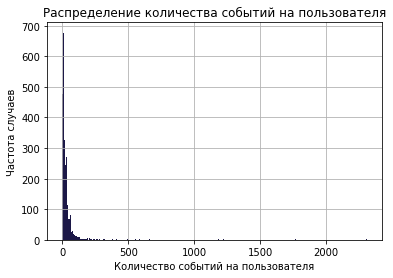

In [11]:
#Группируем события по каждому пользователю, выводим информацию по столбцу событий и строим распределение
event_per_id = log_data.groupby('id').agg({'event_name':'count'}).reset_index()
display(event_per_id['event_name'].describe())
event_per_id['event_name'].hist(bins = 1000, color = '#1c1847')
plt.title('Распределение количества событий на пользователя')
plt.xlabel('Количество событий на пользователя')
plt.ylabel('Частота случаев')
plt.show()

In [12]:
#Посмотрим на количество событий для 90, 95, 99 перцентилей
np.percentile(event_per_id['event_name'], [90, 95, 99])

array([ 64. ,  89. , 200.5])

Полученные данные показывают, что у распределения количества событий очень большой "хвост" вправо - есть аномально большие значения (максимум - 2307 событий на пользователя). Стандартное отклонение вдвое больше среднего значения, а медиана - в полтора раза меньше среднего.

В 99% случаев количество событий на пользователя не превышает 200.


In [13]:
#Не будем пока удалять выбросы, посмотрим, как данные будут вести себя при анализе

#Формируем список id аномальных пользователей 
#abnormal_users_list = list(event_per_id.query('event_name > 1000')['id'])
#print('Число пользователей с аномально большим количеством событий: ', event_per_id.query('event_name > 1000')['id'].nunique())
#Проверка корректности формирования списка
#abnormal_users_list[:5]
#Фильтруем датасет по составленному списку
#log_data_corr = log_data.query('id not in @abnormal_users_list')
#log_data_corr.info()
#print('В результате обработки исходный датасет уменьшился на {:.2%}.'.format(1 - len(log_data_corr) / len(log_data)))
#print('Среднее количество событий на пользователя: {:.0f}'.format(event_per_id.query('event_name < 200')['event_name'].mean()))
#print('Медианное количество событий на пользователя: {:.0f}'.format(event_per_id.query('event_name < 200')['event_name'].median()))
#print('Самое распространенное количество (мода) событий на пользователя:',event_per_id.query('event_name < 200')['event_name'].mode()[0])

Сравним среднюю, моду и медиану количества событий на пользователя. 

In [14]:
print('Среднее количество событий на пользователя: {:.0f}'.format(event_per_id['event_name'].mean()))
print('Медианное количество событий на пользователя: {:.0f}'.format(event_per_id['event_name'].median()))
print('Самое распространенное количество (мода) событий на пользователя:',event_per_id['event_name'].mode()[0])

Среднее количество событий на пользователя: 32
Медианное количество событий на пользователя: 20
Самое распространенное количество (мода) событий на пользователя: 5


Поскольку распределение больше похоже на экспоненциальное, лучше всего тенденцию среднего количества событий будет описывать мода. Она равна пяти, то есть средний пользователь проходит по цепочке событий один раз.

Определим период, за который выгружены логи.

In [15]:
print('Лог содержит данные с {:%d-%m-%Y} по {:%d-%m-%Y}.'.format(log_data['date'].min(), log_data['date'].max()))


Лог содержит данные с 25-07-2019 по 07-08-2019.


Посмотрим на распределение количества событий во времени,чтобы подтвердить равномерность собранных данных.

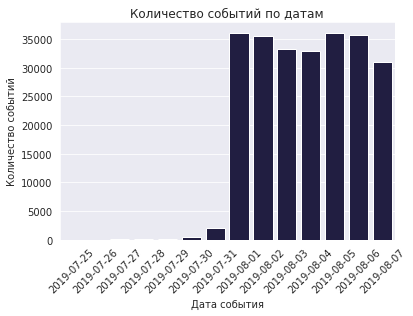

In [16]:
event_date = log_data.pivot_table(index = 'date', values = 'id', aggfunc = 'count').reset_index()
sns.set_style("darkgrid")
sns.barplot(data = event_date, x = 'date', y = 'id', color = '#1c1847')
plt.xticks(rotation = 45)
plt.title('Количество событий по датам')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.show()

Данные, полученные до 1.08.2019, неполные. Их нельзя использовать при анализе.

Удалим их из исходного датасета.

In [17]:
#Для корректной работы среза преобразуем формат столбца с датой
log_data['date'] = log_data['date'].astype('datetime64')
#Создаем список для фильтрации
dates_list = ["2019-08-01", "2019-08-02", "2019-08-03", "2019-08-04", "2019-08-05", "2019-08-06", "2019-08-07"]
log_data_new = log_data.query('date in @dates_list')
print('Датасет уменьшился на {:.2%}.'.format(1 - len(log_data_new) / len(log_data)))

Датасет уменьшился на 1.16%.


In [18]:
print('Количество уникальных пользователей уменьшилось на', log_data['id'].nunique() - log_data_new['id'].nunique())
print('Количество событий уменьшилось на', len(log_data) - len(log_data_new))

Количество уникальных пользователей уменьшилось на 17
Количество событий уменьшилось на 2826


In [19]:
print('После обработки лог содержит данные с {:%d-%m-%Y} по {:%d-%m-%Y}.'.format(log_data_new['datetime'].min(), log_data_new['datetime'].max()))

После обработки лог содержит данные с 01-08-2019 по 07-08-2019.


Проверим, как распределены пользователи по группам эксперимента.

,exp_group,users_number,deviation
0,246,2484,98.91%
1,247,2513,100.07%
2,248,2537,101.02%


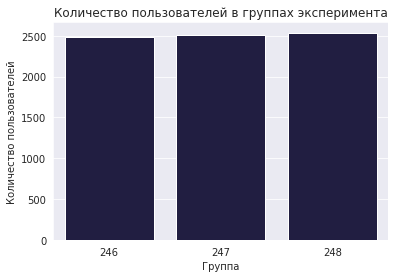

In [20]:
group_pivot = log_data_new.pivot_table(index = 'exp_group', values = 'id', aggfunc = pd.Series.nunique).reset_index()
group_pivot.columns = ['exp_group', 'users_number']
group_pivot['deviation'] = group_pivot['users_number'] / group_pivot['users_number'].mean()
display(group_pivot.style.format({'deviation': '{:.2%}'}))
sns.set_style("darkgrid")
sns.barplot(data = group_pivot, x = 'exp_group', y = 'users_number', color = '#1c1847')
plt.title('Количество пользователей в группах эксперимента')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.show() 

Отклонение количества пользователей от среднего по трем группам составляет около 1%. На большом размере выборки это допустимо.

## Воронка событий <a id="funnel"></a>

Посмотрим, в каком порядке идут события, и построим воронку.

In [21]:
log_data_new_funnel = log_data_new.pivot_table(index = 'event_name', values = 'id', aggfunc = 'count').reset_index().sort_values(by = 'id', ascending = False)
log_data_new_funnel

,event_name,id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


События в таблице идут в таком порядке по убыванию количества просмотров: 
1. Просмотр главного экрана
2. Просмотр экрана с предложениями
3. Переход в корзину
4. Просмотр экрана успешной оплаты
5. Чтение руководства

Последний пункт не является частью цепочки. При построении воронки его учитывать не нужно.

In [22]:
log_data_new_funnel_corr = log_data_new_funnel.query('event_name != "Tutorial"')
fig = go.Figure(go.Funnel(y=log_data_new_funnel_corr['event_name'], x = log_data_new_funnel_corr['id'], marker = {"color": "#1c1847"}), layout_title_text='Воронка событий по частоте')
fig.show()


Построим еще одну воронку - по количеству пользователей, которые проходили эти этапы.

In [23]:
print('Всего пользователей участвовало в эксперименте:', log_data_new['id'].nunique())

Всего пользователей участвовало в эксперименте: 7534


In [24]:
#Сводная таблица количества пользователей по каждому этапу, кроме этапа 'Tutorial', не входящего в цепочку
log_data_new_funnel_2 = log_data_new.query('event_name != "Tutorial"').pivot_table(index = 'event_name', values = 'id', aggfunc = pd.Series.nunique).reset_index()
#Добавляем событие - открытие приложения, чтобы видеть в воронке общее количество пользователей
log_data_new_funnel_2 = log_data_new_funnel_2.append({'event_name': 'ApplicationEnter', 'id':  log_data_new['id'].nunique()}, ignore_index=True).sort_values(by = 'id', ascending = False)
#Конверсия по отношению к общему количеству пользователей приложения
log_data_new_funnel_2['%_users'] = log_data_new_funnel_2['id']/log_data_new['id'].nunique()
display(log_data_new_funnel_2.style.format({'%_users':'{:.2%}'}))

,event_name,id,%_users
4,ApplicationEnter,7534,100.00%
1,MainScreenAppear,7419,98.47%
2,OffersScreenAppear,4593,60.96%
0,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%


Обращает на себя внимание тот факт, что на первый этап (просмотр главного экрана) вышли не все пользователи приложения. 

Возможно, это связано с алгоритмом работы контекстной рекламы, например, в соцсетях, где пользователю предлагается сразу ссылка на конкретный товар.

Еще один вариант объяснения - приложение было запущено до рассматриваемого периода.

In [25]:
fig = go.Figure(go.Funnel(y=log_data_new_funnel_2['event_name'], x = log_data_new_funnel_2['id'],     textposition = 'inside',
    textinfo = 'value+percent previous',
    marker = {'color': '#1c1847'}), layout_title_text='Воронка событий по количеству пользователей')
fig.show()

Воронка показывает, что 38% пользователей не доходят до третьего события - до экрана с предложением товара. Нужно искать проблему на начальном экране приложения (интуитивность интерфейса, работоспособность ссылок и т.д.).

До финального события - окна с подтверждением оплаты - доходит меньше половины всех пользователей, открывших приложение (47,7%).

## Результаты A/A/B-теста <a id="aabtest"></a>

Проведен эксперимент по замене шрифтов в приложении. 

В тестировании участвовали три группы: две контрольные (246, 247) и одна экспериментальная (248):

In [26]:
group_pivot

,exp_group,users_number,deviation
0,246,2484,0.989116
1,247,2513,1.000664
2,248,2537,1.010220


### Проверка гипотезы об отсутствии различий в конверсии двух контрольных групп <a id="a1a2test"></a>

Проверим гипотезу H0 о том, что две контрольные группы не имеют статистически значимых отличий на всех этапах конверсии между событиями.

In [27]:
#Фильтруем данные по номеру группы
log_data_246 = log_data_new.query('exp_group == 246')
log_data_247 = log_data_new.query('exp_group == 247')
log_data_248 = log_data_new.query('exp_group == 248')
#Функция, которая считает пошаговую конверсию в любом датасете
def conv_func(data):
  #Этап чтения мануала исключаем, т.к. он не входит в последовательность событий. Группируем события по кол-ву уникальных пользователей
  data_events = data.query('event_name != "Tutorial"').groupby('event_name').agg({'id':'nunique'}).reset_index().sort_values(by = 'id', ascending = False)
  #Создаем колонку, где строке из столбца с пользователями будет соответствовать значение предыдущей строки этого же столбца. Он нужен для расчета конверсии
  data_events['prev_id'] = data_events['id'].shift(1).fillna(data['id'].nunique()).astype('int')
  #Расчтеный столбец конверсии между этупами
  data_events['conversion'] = data_events['id'] / data_events['prev_id']
  return data_events



In [28]:
#Запускаем написанную функцию
print('Таблица конверсии для набора данных группы 246 (А1):')
display(conv_func(log_data_246))
print('Таблица конверсии для набора данных группы 247 (А2):')
display(conv_func(log_data_247))
print('Таблица конверсии для набора данных группы 248 (А3):')
display(conv_func(log_data_248))

Таблица конверсии для набора данных группы 246 (А1):


,event_name,id,prev_id,conversion
1,MainScreenAppear,2450,2484,0.986312
2,OffersScreenAppear,1542,2450,0.629388
0,CartScreenAppear,1266,1542,0.821012
3,PaymentScreenSuccessful,1200,1266,0.947867


Таблица конверсии для набора данных группы 247 (А2):


,event_name,id,prev_id,conversion
1,MainScreenAppear,2476,2513,0.985277
2,OffersScreenAppear,1520,2476,0.613893
0,CartScreenAppear,1238,1520,0.814474
3,PaymentScreenSuccessful,1158,1238,0.935380


Таблица конверсии для набора данных группы 248 (А3):


,event_name,id,prev_id,conversion
1,MainScreenAppear,2493,2537,0.982657
2,OffersScreenAppear,1531,2493,0.614120
0,CartScreenAppear,1230,1531,0.803396
3,PaymentScreenSuccessful,1181,1230,0.960163


In [29]:
#Объединяем данные по контрольным группам в одну таблицу
A = conv_func(log_data_246).merge(conv_func(log_data_247), on = 'event_name')
A.columns = ['event_name', 'A1', 'prev_step1', 'conversion_A1', 'A2', 'prev_step2', 'conversion_A2']
A

,event_name,A1,prev_step1,conversion_A1,A2,prev_step2,conversion_A2
0,MainScreenAppear,2450,2484,0.986312,2476,2513,0.985277
1,OffersScreenAppear,1542,2450,0.629388,1520,2476,0.613893
2,CartScreenAppear,1266,1542,0.821012,1238,1520,0.814474
3,PaymentScreenSuccessful,1200,1266,0.947867,1158,1238,0.935380


In [30]:
#Пишем функцию проверки статзначимости по z-тесту
def z_test(n1, x1, n2, x2):
  #Конверсии по группам:
  p1 = x1 / n1
  p2 = x2 / n2
  #Общая конверсия
  p = (x1 + x2) / (n1 + n2)
  #Разница между конверсиями
  difference = p1 - p2
  #Расчет z-значения (статистики разницы между конверсиями)
  z_value = difference / mth.sqrt(p * (1 - p) * (1/n1 + 1/n2))
  #Статистика распределена нормально, используем при расчете p_value (среднее 0, ст.отклонение 1)
  distr = st.norm(0, 1)
  #Задаем функцию нормального распределения для расчета критерия 
  p_value = (1 - distr.cdf(abs(z_value))) * 2
  return p_value

In [31]:
#Создаем столбец со значениями  критического уровня статистической значимости с поправкой Бонферрони (на количество проверок)
A['alpha'] = 0.05 / (A.shape[0] * 2)
#Применяем функцию к таблице контрольных групп
#В этом столбце считаем абсолютную конверсию 
A['p_value'] = A.apply(lambda x: z_test(A.iloc[0,2], x['A1'], A.iloc[0,5], x['A2']), axis = 1)
#В этом столбце считаем относительную конверсию 
A['p_value_2'] = A.apply(lambda x: z_test(x['prev_step1'], x['A1'], x['prev_step2'], x['A2']), axis = 1)    
A.style.format({'p_value':'{:.5f}', 'p_value_2':'{:.5f}'})

,event_name,A1,prev_step1,conversion_A1,A2,prev_step2,conversion_A2,alpha,p_value,p_value_2
0,MainScreenAppear,2450,2484,0.986312,2476,2513,0.985277,0.006250,0.75706,0.75706
1,OffersScreenAppear,1542,2450,0.629388,1520,2476,0.613893,0.006250,0.24810,0.26223
2,CartScreenAppear,1266,1542,0.821012,1238,1520,0.814474,0.006250,0.22883,0.63938
3,PaymentScreenSuccessful,1200,1266,0.947867,1158,1238,0.935380,0.006250,0.11457,0.18243


На всех этапах p-value не достигает уровня критической значимости. 

Таким образом, гипотезу об отсутствии различий между контрольными группами не отвергаем.

### Проверка гипотезы об отсутствии различий в конверсии между экспериментальной и каждой из контрольных групп <a id="a1a2btest"></a>

Сравним статистическую значимость различий между экспериментальной и каждой из контрольных групп.

Нулевая гипотеза - статистически значимых различий между группами нет.

H1 - различия статистически значимы.

In [32]:
#Объединяем данные по первой контрольной и экспериментальной группам в одну таблицу
A1B = conv_func(log_data_246).merge(conv_func(log_data_248), on = 'event_name')
A1B.columns = ['event_name', 'A1', 'prev_step_A1', 'conversion_A1', 'B', 'prev_step_B', 'conversion_B']
#Создаем столбец со значениями  критического уровня статистической значимости с поправкой Бонферрони
A1B['alpha'] = 0.05 / (A1B.shape[0] * 2)
#Применяем функцию к таблице
#В этом столбце считаем абсолютную конверсию 
A1B['p_value'] = A1B.apply(lambda x: z_test(A1B.iloc[0,2], x['A1'], A1B.iloc[0,5], x['B']), axis = 1)
#В этом столбце считаем относительную конверсию 
A1B['p_value_2'] = A1B.apply(lambda x: z_test(x['prev_step_A1'], x['A1'], x['prev_step_B'], x['B']), axis = 1)    
A1B.style.format({'p_value':'{:.5f}', 'p_value_2':'{:.5f}'})

,event_name,A1,prev_step_A1,conversion_A1,B,prev_step_B,conversion_B,alpha,p_value,p_value_2
0,MainScreenAppear,2450,2484,0.986312,2493,2537,0.982657,0.006250,0.29497,0.29497
1,OffersScreenAppear,1542,2450,0.629388,1531,2493,0.614120,0.006250,0.20836,0.26843
2,CartScreenAppear,1266,1542,0.821012,1230,1531,0.803396,0.006250,0.07843,0.21122
3,PaymentScreenSuccessful,1200,1266,0.947867,1181,1230,0.960163,0.006250,0.21226,0.14295


Значения p-value не меньше критических. Нулевую гипотезу по отсутствию статзначимых различий между группами A1 и B не отвергаем.

In [33]:
#Объединяем данные по первой контрольной и экспериментальной группам в одну таблицу
A2B = conv_func(log_data_247).merge(conv_func(log_data_248), on = 'event_name')
A2B.columns = ['event_name', 'A2', 'prev_step_A2', 'conversion_A2', 'B', 'prev_step_B', 'conversion_B']
#Создаем столбец со значениями  критического уровня статистической значимости с поправкой Бонферрони
A2B['alpha'] = 0.05 / (A2B.shape[0] * 2)
#Применяем функцию к таблице 
#В этом столбце считаем абсолютную конверсию 
A2B['p_value'] = A2B.apply(lambda x: z_test(A2B.iloc[0,2], x['A2'], A2B.iloc[0,5], x['B']), axis = 1)
#В этом столбце считаем относительную конверсию 
A2B['p_value_2'] = A2B.apply(lambda x: z_test(x['prev_step_A2'], x['A2'], x['prev_step_B'], x['B']), axis = 1)    
A2B.style.format({'p_value':'{:.5f}', 'p_value_2':'{:.5f}'})

,event_name,A2,prev_step_A2,conversion_A2,B,prev_step_B,conversion_B,alpha,p_value,p_value_2
0,MainScreenAppear,2476,2513,0.985277,2493,2537,0.982657,0.006250,0.45871,0.45871
1,OffersScreenAppear,1520,2476,0.613893,1531,2493,0.614120,0.006250,0.91978,0.98694
2,CartScreenAppear,1238,1520,0.814474,1230,1531,0.803396,0.006250,0.57862,0.43649
3,PaymentScreenSuccessful,1158,1238,0.935380,1181,1230,0.960163,0.006250,0.73734,0.00568


Значения p-value не меньше критических. Нулевую гипотезу по отсутствию статзначимых различий между группами A2 и B не отвергаем.

Важный момент: если бы мы не сделали поправку на множественные проверки статзначимости (базовое значение `alpha` разделили на количество проверок, в нашем случае 4), нулевую гипотезу пришлось бы отвергнуть из-за значения p_value2 на поседнем этапе.

### Проверка гипотезы об отсутствии различий в конверсии между экспериментальной и объединённой контрольной группой <a id="abtest"></a>

Последним этапом сравним статзначимость различий в экспериментальной и объединённой контрольной группах.

H0 - статистически значимых различий между группами нет.

In [34]:
#Объединяем данные по первой контрольной и экспериментальной группам в одну таблицу
AB = A.merge(conv_func(log_data_248), on = 'event_name')
AB.rename(columns = {'id':'B', 'prev_id': 'prev_step_B', 'conversion': 'conversion_B'}, inplace = True)
AB['A'] = AB['A1'] + AB['A2']
AB['prev_step_A'] = AB['prev_step1'] + AB['prev_step2']
AB['conversion_A'] = AB['A'] / AB['prev_step_A']
AB = AB[['event_name','A', 'prev_step_A', 'conversion_A', 'B', 'prev_step_B', 'conversion_B']]
#AB.columns = ['event_name', 'A2', 'prev_step_A2', 'conversion_A2', 'B', 'prev_step_B', 'conversion_B']
#Создаем столбец со значениями  критического уровня статистической значимости с поправкой Бонферрони
AB['alpha'] = 0.05 / (AB.shape[0] * 2)
#Применяем функцию к таблице 
#В этом столбце считаем абсолютную конверсию 
AB['p_value'] = AB.apply(lambda x: z_test(AB.iloc[0,2], x['A'], AB.iloc[0,5], x['B']), axis = 1)
#В этом столбце считаем относительную конверсию 
AB['p_value_2'] = AB.apply(lambda x: z_test(x['prev_step_A'], x['A'], x['prev_step_B'], x['B']), axis = 1)    
AB.style.format({'p_value':'{:.5f}', 'p_value_2':'{:.5f}'})

,event_name,A,prev_step_A,conversion_A,B,prev_step_B,conversion_B,alpha,p_value,p_value_2
0,MainScreenAppear,4926,4997,0.985791,2493,2537,0.982657,0.006250,0.29425,0.29425
1,OffersScreenAppear,3062,4926,0.621600,1531,2493,0.614120,0.006250,0.43426,0.53086
2,CartScreenAppear,2504,3062,0.817766,1230,1531,0.803396,0.006250,0.18176,0.23906
3,PaymentScreenSuccessful,2358,2504,0.941693,1181,1230,0.960163,0.006250,0.60043,0.01711


Сравнение показателей объединённой контрольной группы с экспериментальной дает отсутствие статистически значимых различий при выбранном уровне значимости 0,00625. 

Нужно отметить, что при уменьшении этого порога повышается вероятнсть ошибки второго рода (ошибочно не отвергнуть нулевую гипотезу). Однако уровень p-value достаточно высок. При сравнении абсолютных изменений конверсии нельзя отвергнуть нулевую гипотезу даже при нескорректированном `alpha`.

## Выводы <a id="conclusions"></a>

Проект состоял из двух частей. В первой части мы исследовали все полученные при A/A/B-тестировании данные, чтобы увидеть воронку событий. Она показала:
* **Около 1,5% пользователей заходят в приложение, минуя главный экран**. Нужно разобраться в причинах этого нетипичного маршрута
* **До экрана с выбором продуктов не доходят 38% пользователей приложения**. Это большой процент. Нужно исследовать корректность работы приложения на этом этапе
* В целом **из общего количества пользователей около половины** проходят всю цепочку событий и **успешно оплачивают заказ**. Это неплохой показатель, но его можно улучшить, проверив пункты выше.

Исследование результатов A/A/B-теста показало:
* Группы в исследовании отличаются друг от друга по размеру не больше чем на 1%. Это допустимое отклонение
* Контрольные группы подобраны и разбиты корректно, гипотеза о наличии статистически значимых различий в них не отвергнута
* Конверсия каждой контрольной группы (и совокупной контрольной) не имеет статистически значимых различий с результатами экспериментальной. Это значит, что **эксперимент с заменой шрифтов в приложении не дал большого прироста конверсии**.